## Demonstration of tensor-SSA method for decomposing multidimensional time series

### Auxilary functions

In [63]:
import numpy as np
import scipy.linalg as linalg
from matplotlib import pyplot as plt
from ..src.multiD_ssa import multiD_SSA_decomp

%matplotlib inline 

In [64]:
def plot_c_vector_norms(decomposer: multiD_SSA_decomp):
    """method draw norms of c vectors of CPD decomposition of trajectory tensor as they represent 
        the weight of each factor in decomposition. Represention in decsending order.

        Traj_tensor = \sum^r a_i \times b_i \times c_i

    :param multiD_SSA_decomp decomposer:
    :return: indecies of c vecs by their norms descendly
    """
    c_vecs: np.ndarray = decomposer.factors[2]
    c_vecs_norms = linalg.norm(c_vecs, axis=0)
    c_vecs_order = np.argsort(c_vecs_norms)[::-1]
    c_vecs_norms.sort()
    c_vecs_norms = np.flip(c_vecs_norms)

    fig, ax = plt.subplots()
    ax.plot(c_vecs_norms, marker='.')
    ax.grid(True)
    ax.set_title('Norms of c vectors descendly')
    ax.set_xlabel('vector number')
    ax.set_ylabel('$|| \cdot ||_2$')

    return c_vecs_order


def plot_decomposed_signals(decomposer: multiD_SSA_decomp, t: np.ndarray):
    """method draws (n, r) grid of plots: each row "i" represent decomposition of i-th component of multidimensional signal as 
       r signals

    :param multiD_SSA_decomp decomposer:
    :param t: time grid
    """
    # dimensionality of signal
    dim = len(decomposer.time_series)

    fig, ax = plt.subplots(nrows=dim, ncols=len(decomposer.grouping), figsize=(15, 15))
    for row in range(dim):
        for col in range(len(decomposer.grouping)):
            ax[row][col].plot(t, decomposer.component_signals[col][row])
            ax[row][col].grid(True)
            ax[row][col].set_title(f"Signal #{row + 1}, component #{col + 1}")
    


def plot_initial_and_restored(decomposer: multiD_SSA_decomp, t: np.ndarray, init_sig: np.ndarray):
    """draws initial and restored components of multid signals

    :param multiD_SSA_decomp decomposer: _description_
    :param np.ndarray t: _description_
    :param np.ndarray init_sig: _description_
    """
    # dimensionality of signal
    dim = len(decomposer.time_series)

    fig, ax = plt.subplots(nrows=dim, figsize=(10, 10))
    for row in range(dim):
        cur_restored_sig = np.zeros(t.size)
        for col in range(len(decomposer.grouping)):
            cur_restored_sig += decomposer.component_signals[col][row]

        ax[row].plot(t, cur_restored_sig, label='restored')
        ax[row].plot(t, init_sig[row], label='intial', linestyle='dashed')
        ax[row].legend()
        ax[row].grid(True)
        ax[row].set_title(f"Signal #{row + 1}")

### Example 1: sine's with diffrent frequency

In [65]:
# set frequencies
freq1 = 1
freq2 = 2
freq3 = 3

# set length of time series
tot_time = 10
# set freq of sampling
sampling_rate = 10
# create time series
t = np.linspace(0, tot_time, sampling_rate * (tot_time - 0))
sin1 = np.sin(freq1 * t)
sin2 = np.sin(freq2 * t)
sin3 = np.sin(freq3 * t)

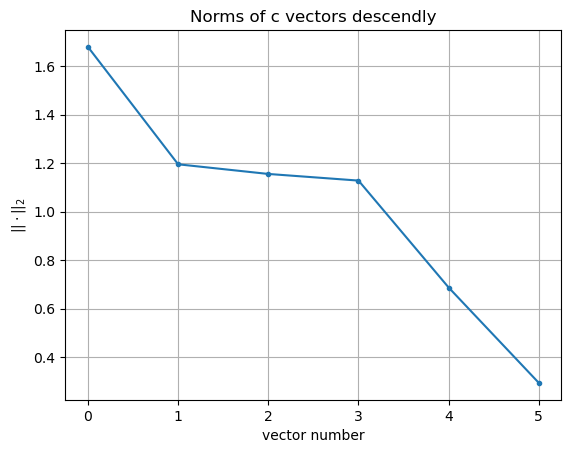

In [66]:
# fixing the stochastics for determenistic CPD decomposition
np.random.seed(41)

# set parameters for tSSA
window_size = 50
CPD_rank = 6

decomposer = multiD_SSA_decomp([sin1.copy(), sin2.copy(), sin3.copy()], window_size, CPD_rank)

# make tensor decomposition
decomposer.decompose()

# draw "singular values" which are kind of norms of c vectors
index_order = plot_c_vector_norms(decomposer)

In [67]:
# let's group according to the proximity of this values
decomposer.group_components([(index_order[0], ), (index_order[1], index_order[2], index_order[3]), (index_order[4], index_order[5])])

# now we can obtain decomposition
decomposer.extract_signals()

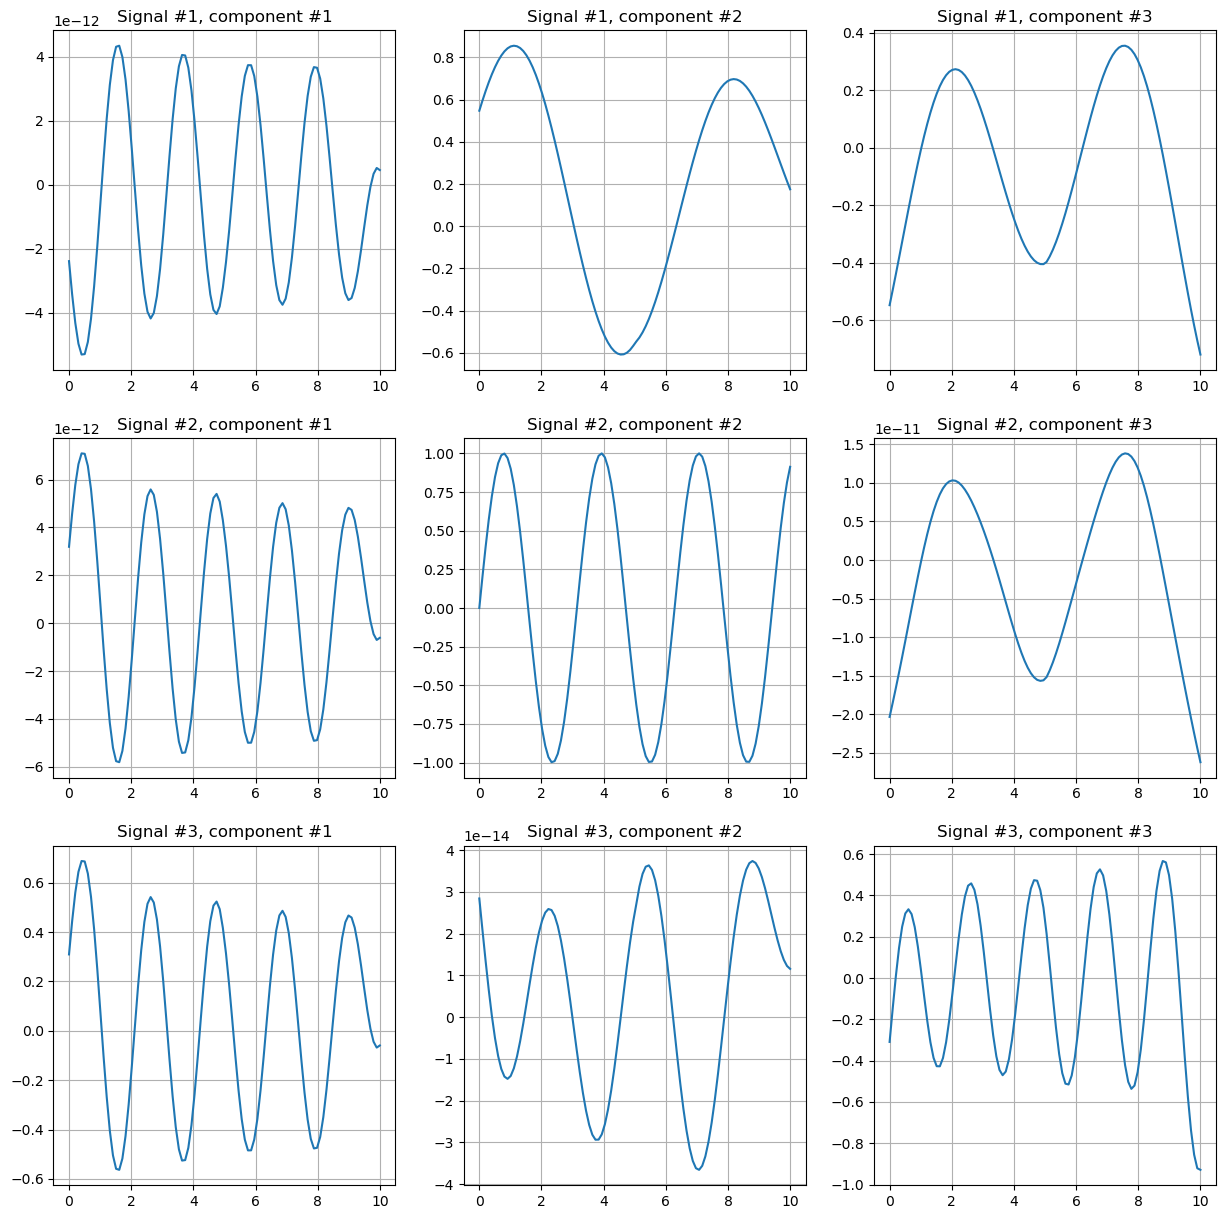

In [68]:
# draw decompositions
plot_decomposed_signals(decomposer, t)

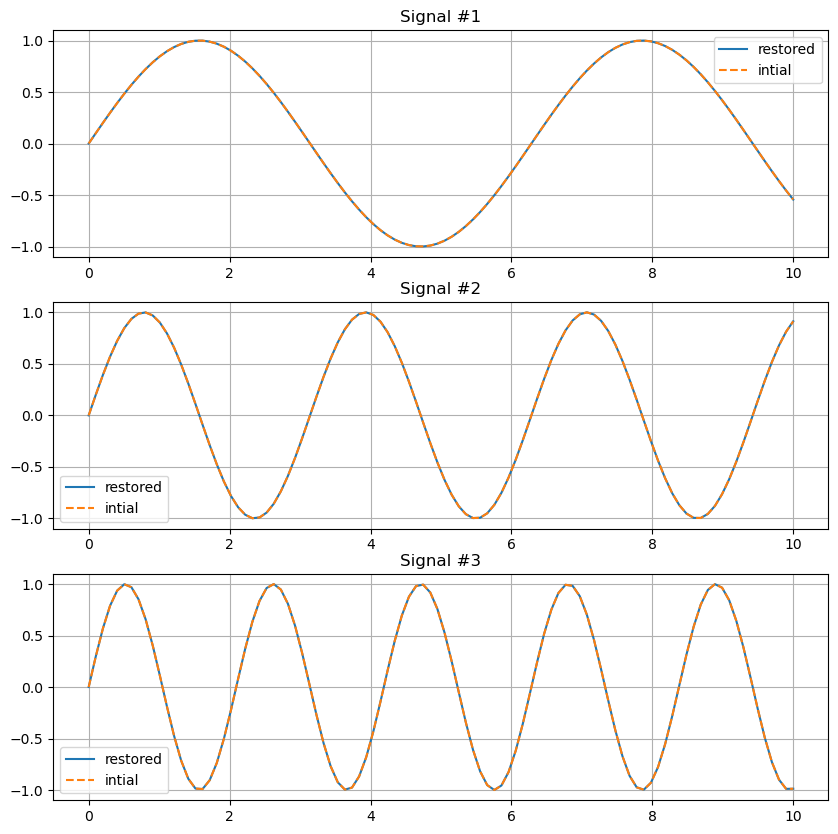

In [69]:
# draw initial and restored results
plot_initial_and_restored(decomposer, t, [sin1, sin2, sin3])

We see rather good results!

### Example 2: household power consumption

<img src="https://www.worldatlas.com/r/w1200/upload/fe/26/d1/thinkstockphotos-488549900.jpg" width="700" height="500">

#### Extracting data

The [data](https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption) contains consumption of energy by 3 entites in a house: kitchen, loundry and water heater + air conditioner. This is 3d signal we are going to decompose. Our time period will be 1 year.

In [9]:
import pandas as pd

raw_data = pd.read_csv("./data/household_power_consumption.csv")
raw_data.rename(columns={'Sub_metering_1': 'kitchen_power', 'Sub_metering_2': 'loundry_power', 'Sub_metering_3': 'heater_conditioner_power'},
                inplace=True)
raw_data.head()

/tmp/ipykernel_27295/3132433488.py:3: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv("./data/household_power_consumption.csv")


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,kitchen_power,loundry_power,heater_conditioner_power
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [10]:
# convert strings to pandas dates
raw_data['Date'] = pd.to_datetime(raw_data['Date'], dayfirst=True)

# slice one year, say 2008
raw_data = raw_data[raw_data['Date'] >= pd.to_datetime('01/01/2008', dayfirst=True)]
raw_data = raw_data[raw_data['Date'] <= pd.to_datetime('30/12/2008', dayfirst=True)]

# drop unnessasary columns
raw_data = raw_data.drop(columns=['Time', 'Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity'])

In [11]:
# clean data
print(raw_data['kitchen_power'].__len__())
temp = (raw_data['kitchen_power'].str.find('?') != -1)
temp1 = raw_data['kitchen_power'][temp == True]
raw_data.drop(temp1.index, inplace=True)
# checking successful elemination
print(raw_data['kitchen_power'].__len__())

temp = (raw_data['loundry_power'].str.find('?') != -1)
temp1 = raw_data['loundry_power'][temp == True]
raw_data.drop(temp1.index, inplace=True)
print(raw_data['loundry_power'].__len__())

525600
525465
525465


In [12]:
# change type of column to float
raw_data['kitchen_power'] = pd.to_numeric(raw_data['kitchen_power'])
raw_data['loundry_power'] = pd.to_numeric(raw_data['loundry_power'])
raw_data.dtypes

Date                        datetime64[ns]
kitchen_power                      float64
loundry_power                      float64
heater_conditioner_power           float64
dtype: object

In [13]:
# average information so we have daywise consumption
raw_data = raw_data.groupby('Date').mean()
raw_data.head()

,kitchen_power,loundry_power,heater_conditioner_power
Date,,,
2008-01-01,1.709028,1.902083,8.579861
2008-01-02,0.000000,2.148611,6.240972
2008-01-03,0.784722,0.587500,4.632639
2008-01-04,0.861806,3.698611,8.161111
2008-01-05,1.467361,0.198611,10.132639


Text(0.5, 1.0, 'Electricity consumption by 3 entities during one year')

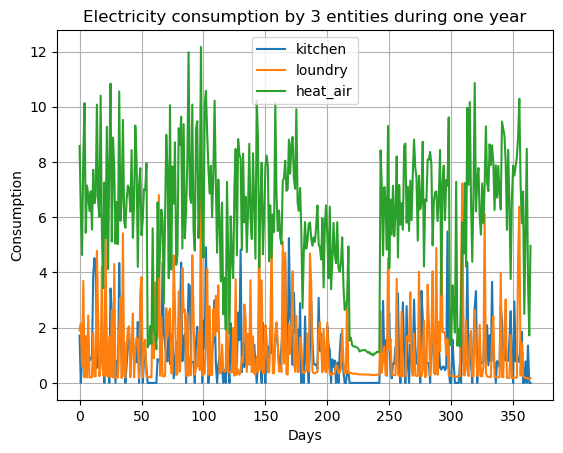

In [43]:
# get our time series
kitchen = raw_data['kitchen_power'].to_numpy(copy=True)
loundry = raw_data['loundry_power'].to_numpy(copy=True)
heat_air = raw_data['heater_conditioner_power'].to_numpy(copy=True)
signals = [kitchen, loundry, heat_air]

# display signals in time
fig, ax = plt.subplots()
ax.plot(kitchen, label='kitchen')
ax.plot(loundry, label='loundry')
ax.plot(heat_air, label='heat_air')
ax.grid(True)
ax.legend()
ax.set_xlabel('Days')
ax.set_ylabel('Consumption')
ax.set_title('Electricity consumption by 3 entities during one year')

#### Decomposing consumption

In [54]:
# fixing the stochastics for determenistic CPD decomposition
np.random.seed(41)

# shrink data as its size is to heavy for ordinary computer to make CPD-decomp.
for i in range(len(signals)):
    signals[i] = signals[i][:200]


# creating decomposer
window_size = 100
CPD_rank = 5
decomposer = multiD_SSA_decomp(signals.copy(), L=window_size, r=CPD_rank)

In [55]:
decomposer.decompose()

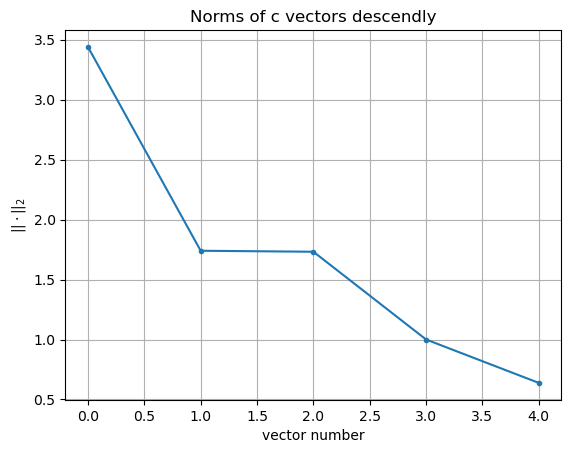

In [56]:
# display c vectors + gain their indecies sorted accordingly to their norms
index_order = plot_c_vector_norms(decomposer)

In [57]:
# let's group according to this values
decomposer.group_components([(index_order[0], ), (index_order[1], index_order[2]), (index_order[3], index_order[4])])

# extract signals
decomposer.extract_signals()

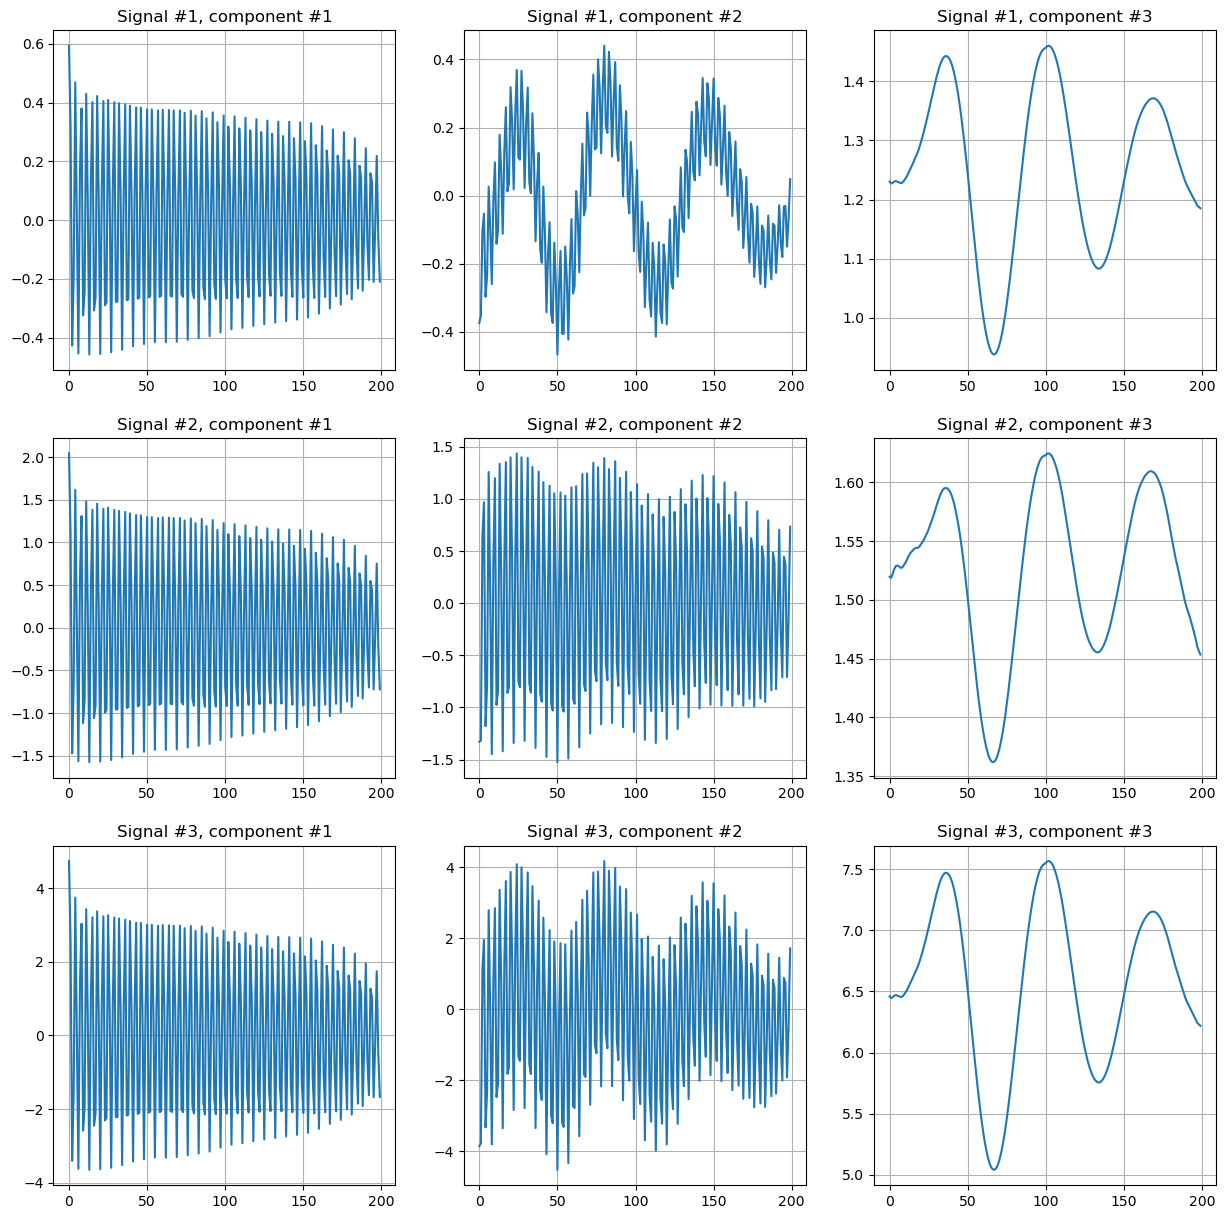

In [61]:
# display components
plot_decomposed_signals(decomposer, t=np.arange(200))

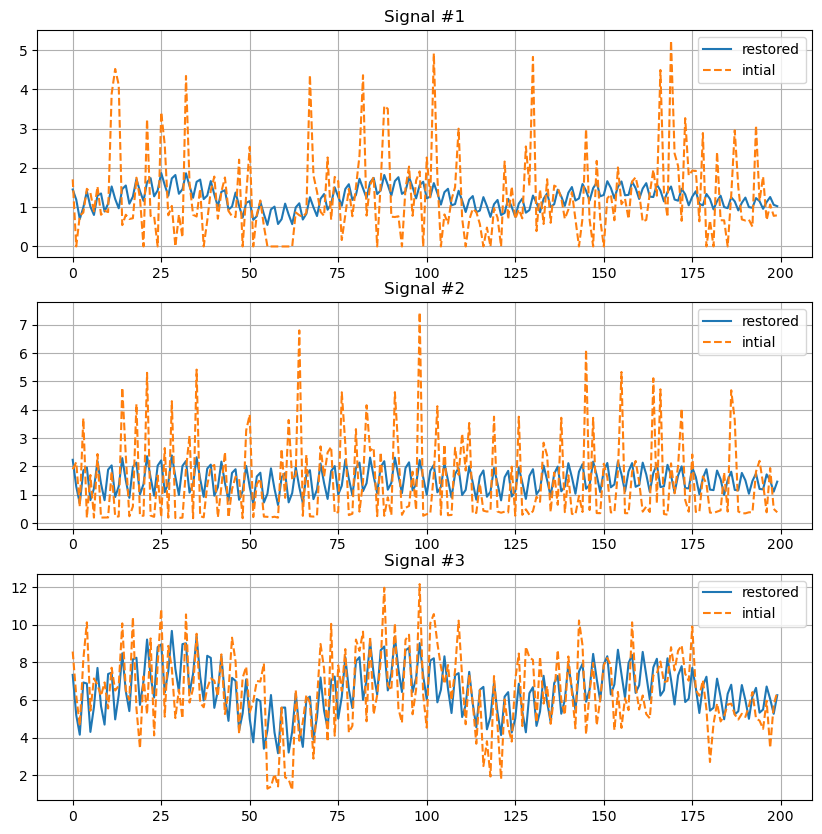

In [62]:
# display init and restored signals
plot_initial_and_restored(decomposer, t=np.arange(200), init_sig=signals)

### Accelerometery

<img src="https://images.fineartamerica.com/images-medium-large/1-biomechanics-historical-artwork-mehau-kulyk.jpg" width="500" height="600">

#### Extracting data

We will get the [accelerometry](https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones) of the standing person and decompose it

In [150]:
# descriptors of file's with accelerometry
acc_x_file = open(r'./data/UCI_HAR_Dataset/test/Inertial Signals/body_acc_x_test.txt', 'r')
acc_y_file = open(r'./data/UCI_HAR_Dataset/test/Inertial Signals/body_acc_y_test.txt', 'r')
acc_z_file = open(r'./data/UCI_HAR_Dataset/test/Inertial Signals/body_acc_z_test.txt', 'r')

# with labels representing types of activity of participants
labels_file = open(r'./data/UCI_HAR_Dataset/test/y_test.txt')

In [151]:
acc_x = []
acc_y = []
acc_z = []

# '5' is the label for 'standing'. Reading accelerometry of this activity
for label in labels_file.readlines():
    if label[0] != '5':
        break

    current_acc_x = acc_x_file.readline().split(' ')
    # removing '\n'
    current_acc_x = current_acc_x[:-1]
    # removing '' elements
    current_acc_x = list(filter(lambda x: x != '', current_acc_x))
    # casting to float values
    current_acc_x = list(map(lambda x: float(x), current_acc_x))
    acc_x.extend(current_acc_x)

    current_acc_y = acc_y_file.readline().split(' ')
    # removing '\n'
    current_acc_y = current_acc_y[:-1]
    # removing '' elements
    current_acc_y = list(filter(lambda x: x != '', current_acc_y))
    # casting to float values
    current_acc_y = list(map(lambda x: float(x), current_acc_y))
    acc_y.extend(current_acc_y)

    current_acc_z = acc_z_file.readline().split(' ')
    # removing '\n'
    current_acc_z = current_acc_z[:-1]
    # removing '' elements
    current_acc_z = list(filter(lambda x: x != '', current_acc_z))
    # casting to float values
    current_acc_z = list(map(lambda x: float(x), current_acc_z))
    acc_z.extend(current_acc_z)

In [152]:
# split time series into 250 groups and average along this groups to shrink the data
acc_x = np.array_split(acc_x, 250)
acc_x = [np.mean(ar) for ar in acc_x]
acc_x = np.array(acc_x)

acc_y = np.array_split(acc_y, 250)
acc_y = [np.mean(ar) for ar in acc_y]
acc_y = np.array(acc_y)

acc_z = np.array_split(acc_z, 250)
acc_z = [np.mean(ar) for ar in acc_z]
acc_z = np.array(acc_z)

signals = [acc_x, acc_y, acc_z]

# time ticks
t = np.arange(acc_x.size)

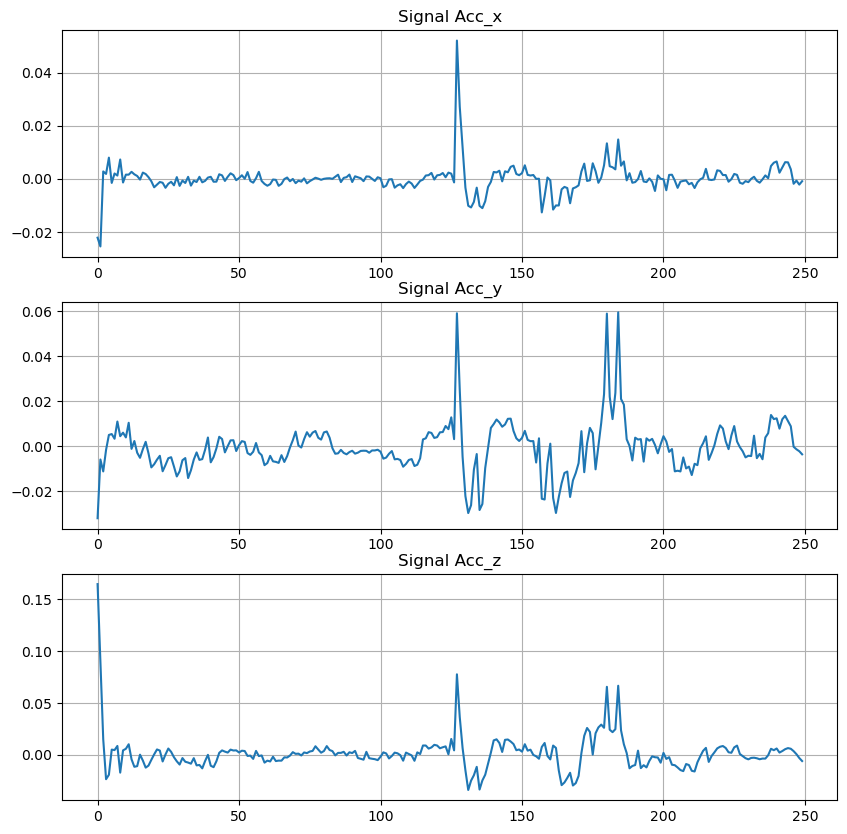

In [155]:
# displaying signals
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
for i, sig in enumerate(signals):
    ax[i].plot(sig)
    ax[i].grid(True)
    ax[i].set_title('Signal Acc_' + chr(ord('x') + i))

#### Decomposing accelerometry

In [156]:
# fixing the stochastics for determenistic CPD decomposition
np.random.seed(41)

# creating decomposer
window_size = 100
CPD_rank = 7
decomposer = multiD_SSA_decomp(signals.copy(), L=window_size, r=CPD_rank)

In [157]:
decomposer.decompose()

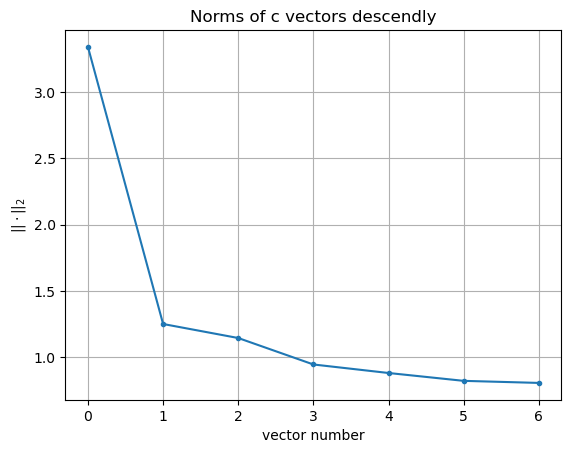

In [158]:
# display c vectors + gain their indecies sorted accordingly to their norms
index_order = plot_c_vector_norms(decomposer)

In [159]:
# let's group according to this values
decomposer.group_components([(index_order[0], ), (index_order[1], index_order[2]), 
                             (index_order[3], index_order[4], index_order[5], index_order[6])])

# extract signals
decomposer.extract_signals()

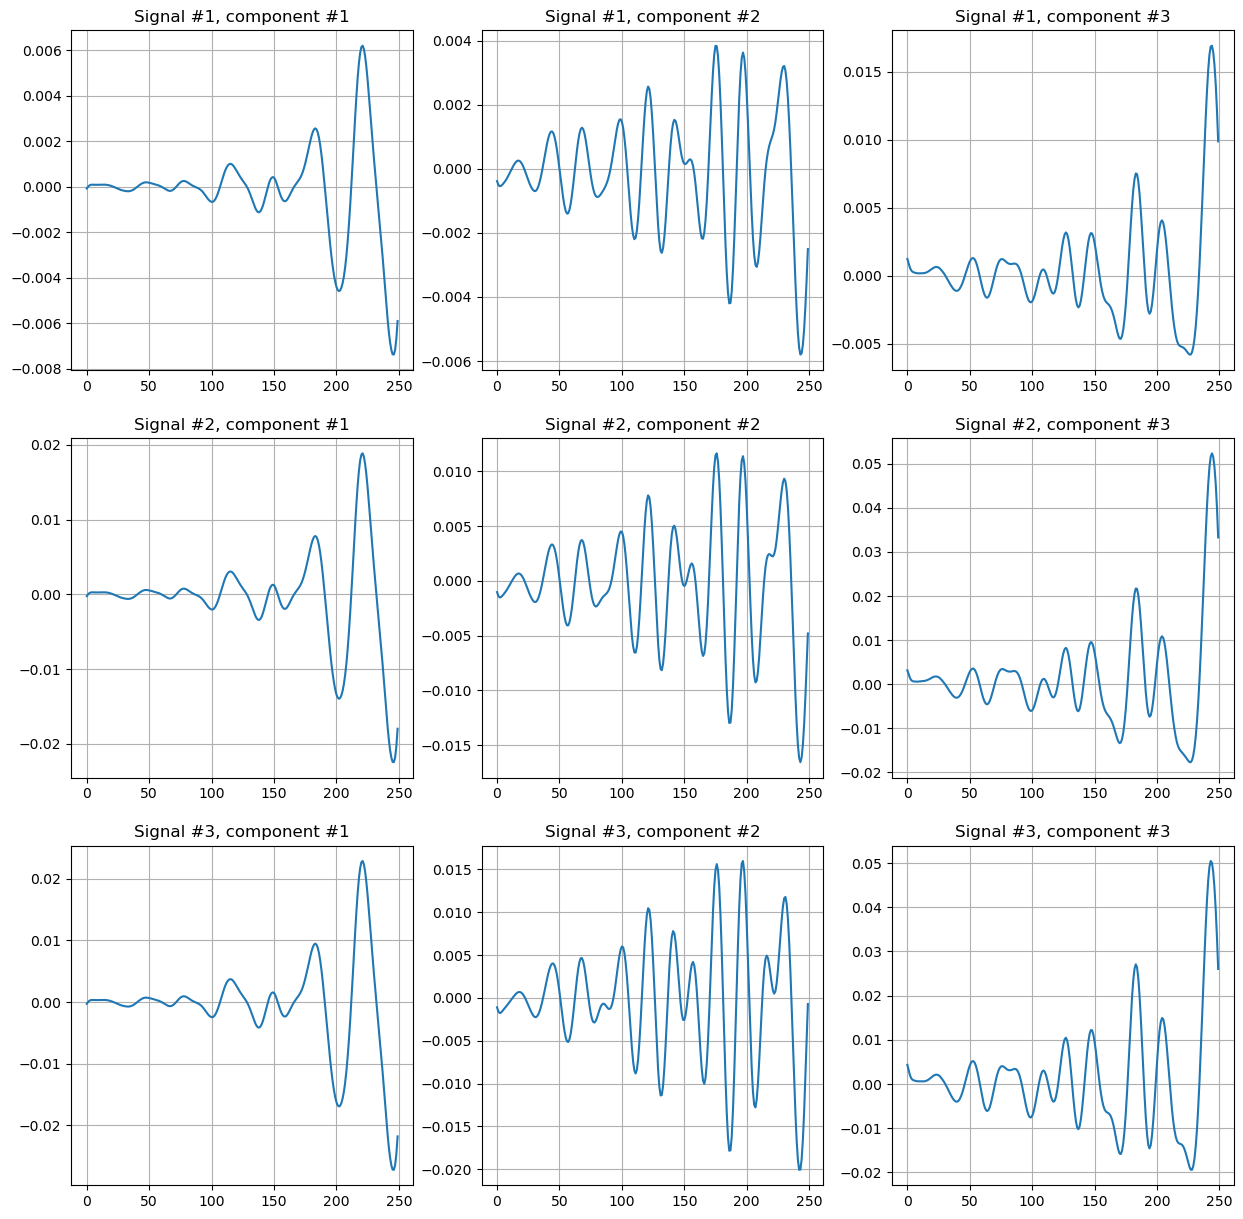

In [161]:
# display components
plot_decomposed_signals(decomposer, t=t)

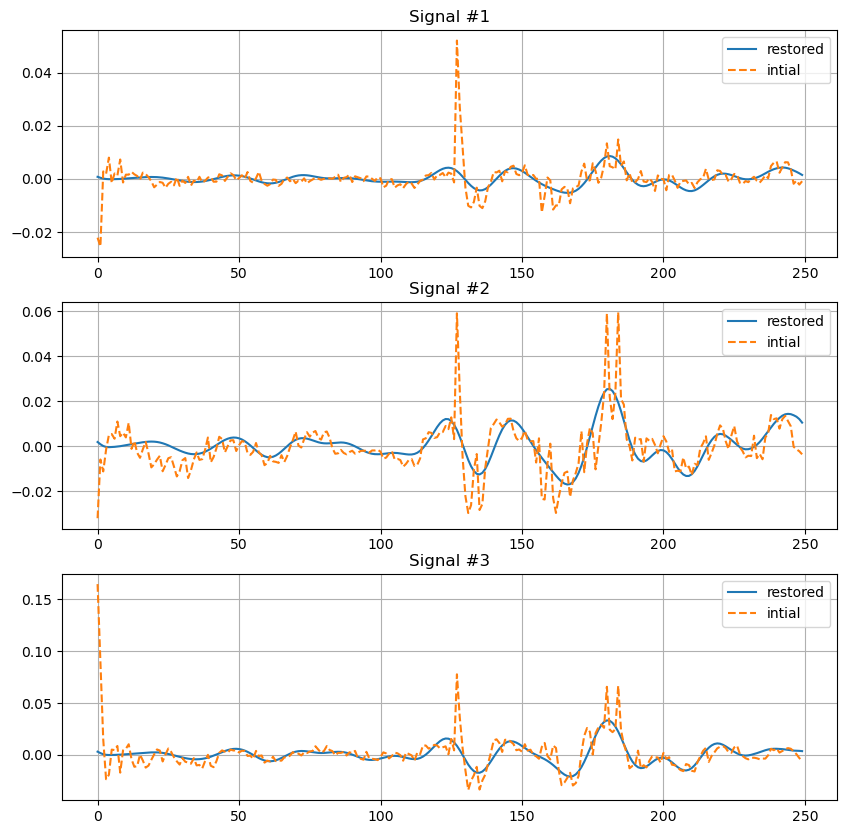

In [163]:
# display init and restored signals
plot_initial_and_restored(decomposer, t=t, init_sig=signals)

### Building trajectory matrix

Classical SSA method relies on applying SVD to the trajectory matrix of the signal. Imagine we have simple time series:

<div align="center">

![title](../figs/title.png)

</div>

Let us have window size for method L=5. That means we will have slicing window of size 5 which will move along our time series with step of 1 element. At each step we extract slice of the time series and put as column in matrix, one by one. The first iteration would look like this: 

<div align="center">

![title](../figs/first_round.png)

</div>

Next iteration:

<div align="center">

![title](../figs/second_round.png)

</div>

And so on. At last window will reach the end of time series and the whole trajectory matrix will be build:

<div align="center">

![title](../figs/last_round.png)

</div>

Elements on the antidiagonals are equal. Such matrices are called hankel matrices.

In tensor-SSA trajectory matricies of each component of multidimensional signal are piled up together to form 3d tensor. After, tensor CP decompostion is applied which is similar to applying SVD for matrix.

### Hankelization

In classical SSA after grouping stage (summing up factors of SVD decomposition within each group) we are supposed to have an output of trajectory matrices which are correspond to decomposition of initial signal. But in most cases it is impossible to receive exactly trajectory matrices meaning elements on the antidiagonals won't be similar. Nonetheless frequently they are almost similar. So to resolve this situation and receive trajectory matrix we can **hankelize** such matrices - just substituate elements on each antidiagonal with the average on this antdiagonal. The output is desireable trajectory matrix!

<div align="center">

![title](../figs/hankelization.png)

</div>